If we learn something so far, that is machine learning is not only applying an algorithm and get the predictions.(Not so much commodization after all) It has quite a lot of different and moving parts for a given problem. Steps(feature extraction, feature selection, classifier, evaluation) follows a sequential order. 

Would it be perfect if we could wrap all of the steps in one object and then do the parameter search(i.e. grid parameter search) for cross validation in that object. Pipeline in Scikit-Learn exactly wraps these sequential steps for us. Further, if we have two estimators in the __pipeline__(say we apply PCA to reduce dimension in the input and then apply SVM), we would need only once to use the `fit` function in the estimator. Pipeline automatically applies the correct steps for you to get the correct output at the end of the pipeline.

Still not convinced? What if I say, serializing one `pipeline` instead of serializing `vectorizer`, `feature_selector` and `classifier` separately and then deploying into production makes much easier.(More on to this in the next notebook) This was a quick win for the pipeline. Let's see how one might use it in classification.

In [12]:
%matplotlib inline
import csv
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn import cross_validation 
from sklearn import datasets
from sklearn import decomposition
from sklearn import ensemble
from sklearn import feature_extraction
from sklearn import feature_selection
from sklearn import grid_search
from sklearn import metrics
from sklearn import naive_bayes
from sklearn import pipeline
from sklearn import tree

import seaborn as sns

pd.set_option('display.max_columns', None)

_DATA_DIR ='data'
_SPAM_DATA_PATH = os.path.join(_DATA_DIR, 'SMSSpamCollection')

### [Dataset Explanation](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection)
- A collection of 425 SMS spam messages was manually extracted from the Grumbletext Web site. This is a UK forum in which cell phone users make public claims about SMS spam messages, most of them without reporting the very spam message received. The identification of the text of spam messages in the claims is a very hard and time-consuming task, and it involved carefully scanning hundreds of web pages. The Grumbletext Web site is: [Web Link]. 
- A subset of 3,375 SMS randomly chosen ham messages of the NUS SMS Corpus (NSC), which is a dataset of about 10,000 legitimate messages collected for research at the Department of Computer Science at the National University of Singapore. The messages largely originate from Singaporeans and mostly from students attending the University. These messages were collected from volunteers who were made aware that their contributions were going to be made publicly available. The NUS SMS Corpus is avalaible at: [Web Link]. 
- A list of 450 SMS ham messages collected from Caroline Tag's PhD Thesis available at [Web Link]. 
- Finally, we have incorporated the SMS Spam Corpus v.0.1 Big. It has 1,002 SMS ham messages and 322 spam messages and it is public available at: [Web Link]. This corpus has been used in the following academic researches: 

In [13]:
df = pd.read_csv(_SPAM_DATA_PATH, sep='\t', header=None, names=['Label', 'Text'])

In [14]:
df.head()

Label                                               Text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

Nothing very fancy. Let's convert the pandas dataframe into a numpy matrix, and then do a cross validation.

In [15]:
y = (df.Label == 'ham').values.astype(int)
X = df.Text.values

In [16]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=0)

### Let's Create our pipeline

In [17]:
pipe = pipeline.Pipeline([('vect', feature_extraction.text.CountVectorizer()),
                          ('tfidf', feature_extraction.text.TfidfTransformer()),
                          ("bernoulli", naive_bayes.BernoulliNB()),
                         ])

In [18]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...e_idf=True)), ('bernoulli', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))])

Functions that are applicable to estimators are also applicable to Pipelines. That is one of the most powerful premise of the pipeline after all. 

In [19]:
metrics.accuracy_score(pipe.predict(X_test), y_test)

0.98116591928251118

By now, we know that this score is not very meaningful, let's look at the confusion matrix!

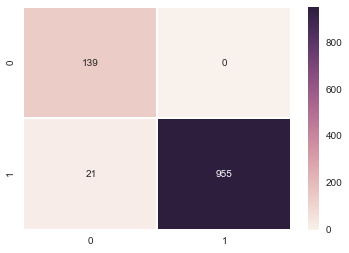

In [20]:
sns.heatmap(metrics.confusion_matrix(pipe.predict(X_test), y_test), annot=True,  fmt='');

In [21]:
print(metrics.classification_report(pipe.predict(X_test), y_test))

             precision    recall  f1-score   support

          0       0.87      1.00      0.93       139
          1       1.00      0.98      0.99       976

avg / total       0.98      0.98      0.98      1115



This is actually pretty good. We classify all of the spam as spam whereas couple of normal messages get into spam folder. Not ideal but pretty good for our first try. 

Upto here, you may start convincing yourself how pipeline would be much better and useful and easier than applying each separate component in the machine learning pipeline. 

## Grid Search in Pipeline

One might apply grid search to the pipeline similar to what we did on the estimator as well. Then one may ask, how do we pass parameters for vectorizer, feature selector and classifier. In the grid search of an estimator, this would be easy as you could pass a `dictionary` which has the keys for the parameters and the parameters as lists that you want to optimize. However, the things in `pipeline` is not that straightforward. First, what if two estimators share the same parameter name and you want to give different values in the search space. What if you do not want to pass any list of parameter to one and pass to the other one? In order to handle this ambiguity, `pipeline` accepts parameters in the form of `{name}__{parameter}` in the dictionary where the `{name}` is the name of the step that you are passing to the pipeline and the parameter is the parameter name that you want to optimize in that step.

<h4> Why double leading underscore?</h4>
> <b>__double_leading_underscore</b>: when naming a class attribute, invokes name mangling (inside class FooBar, __boo becomes _FooBar__boo; ) 

From [PEP 8](http://legacy.python.org/dev/peps/pep-0008/)

In the pipeline, we have only two steps: `pca` and `gbf`. There will be two different parameter family in the parameters dictionary; the ones that start with `vectorizer` and the ones start with `gbf`, both of the parameter names will be followed by `__`(double underscore) and then the original parameter name. For an example, if I want to pass `n_estimators` as a parameter to `GradientBoostingClassifier` which was named `gbf` in the pipeline, I need to pass as `gbf_n_estimators`. Since I will be looking at different values for each parameter, I will pass a list in the values of that dictionary.

In [22]:
params = dict(vect__max_df=[0.5, 1.0],
              vect__max_features=[None, 10000, 200000],
              vect__ngram_range=[(1, 1), (1, 2)],
              tfidf__use_idf=[True, False],
              tfidf__norm=['l1', 'l2'],
              bernoulli__alpha=[0, .5, 1],
              bernoulli__binarize=[None, .1, .5],
              bernoulli__fit_prior=[True, False]
             )

After preparing the parameters, we are ready to pass this parameter and the pipeline to the `RandomizedSearchCV`.

Wait, what? I thought we are using `GridSearchCV` like we did earlier notebook. Oh, that. Instead of searching __all__ the parameters in the parameter space, `RandomizedSearchCV` makes a randomized search. The total number of parameters that have been tried for optimizing the search parameters is determined by an optional parameter `n_iter`. If you set the `n_iter` to be 20, then 20 different total number of parameter combinations will be tried out in optimizing the parameter search space. 

In [23]:
n_iter_search = 100
random_search = grid_search.RandomizedSearchCV(pipe, param_distributions=params,
                                   n_iter=n_iter_search)
 

In [24]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...e_idf=True)), ('bernoulli', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))]),
          fit_params={}, iid=True, n_iter=100, n_jobs=1,
          param_distributions={'vect__ngram_range': [(1, 1), (1, 2)], 'vect__max_df': [0.5, 1.0], 'tfidf__use_idf': [True, False], 'tfidf__norm': ['l1', 'l2'], 'bernoulli__binarize': [None, 0.1, 0.5], 'bernoulli__fit_prior': [True, False], 'bernoulli__alpha': [0, 0.5, 1], 'vect__max_features': [None, 10000, 200000]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring=None, verbose=0)

In [25]:
random_search.best_estimator_

Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.5, max_features=200000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        ..._idf=True)), ('bernoulli', BernoulliNB(alpha=0.5, binarize=0.1, class_prior=None, fit_prior=False))])

In [26]:
random_search.grid_scores_

[mean: 0.97151, std: 0.00259, params: {'vect__ngram_range': (1, 1), 'vect__max_df': 0.5, 'tfidf__use_idf': False, 'tfidf__norm': 'l2', 'bernoulli__binarize': 0.1, 'bernoulli__alpha': 1, 'bernoulli__fit_prior': True, 'vect__max_features': None},
 mean: 0.98070, std: 0.00208, params: {'vect__ngram_range': (1, 1), 'vect__max_df': 0.5, 'tfidf__use_idf': True, 'tfidf__norm': 'l2', 'bernoulli__binarize': 0.1, 'bernoulli__alpha': 0.5, 'bernoulli__fit_prior': True, 'vect__max_features': None},
 mean: 0.87054, std: 0.00110, params: {'vect__ngram_range': (1, 2), 'vect__max_df': 0.5, 'tfidf__use_idf': True, 'tfidf__norm': 'l1', 'bernoulli__binarize': 0.1, 'bernoulli__alpha': 0.5, 'bernoulli__fit_prior': False, 'vect__max_features': 10000},
 mean: 0.90913, std: 0.00143, params: {'vect__ngram_range': (1, 2), 'vect__max_df': 0.5, 'tfidf__use_idf': True, 'tfidf__norm': 'l2', 'bernoulli__binarize': None, 'bernoulli__alpha': 0.5, 'bernoulli__fit_prior': False, 'vect__max_features': 10000},
 mean: 0.870

But we know that the classification accuracy is not the best metric to optimize as we already have a quite high classification accuracy. Let's optimize for `f1` score by passing optional `scoring='f1'`!

In [27]:
random_search = grid_search.RandomizedSearchCV(pipe, param_distributions=params,
                                   n_iter=n_iter_search, scoring='f1')

In [28]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...e_idf=True)), ('bernoulli', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))]),
          fit_params={}, iid=True, n_iter=100, n_jobs=1,
          param_distributions={'vect__ngram_range': [(1, 1), (1, 2)], 'vect__max_df': [0.5, 1.0], 'tfidf__use_idf': [True, False], 'tfidf__norm': ['l1', 'l2'], 'bernoulli__binarize': [None, 0.1, 0.5], 'bernoulli__fit_prior': [True, False], 'bernoulli__alpha': [0, 0.5, 1], 'vect__max_features': [None, 10000, 200000]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring='f1', verbose=0)

In [29]:
random_search.best_estimator_

Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        s...e_idf=True)), ('bernoulli', BernoulliNB(alpha=0.5, binarize=0.1, class_prior=None, fit_prior=True))])

In [30]:
random_search.grid_scores_

[mean: 0.92951, std: 0.00016, params: {'vect__ngram_range': (1, 2), 'vect__max_df': 0.5, 'tfidf__use_idf': False, 'tfidf__norm': 'l2', 'bernoulli__binarize': 0.5, 'bernoulli__alpha': 1, 'bernoulli__fit_prior': True, 'vect__max_features': 10000},
 mean: 0.96794, std: 0.00012, params: {'vect__ngram_range': (1, 1), 'vect__max_df': 1.0, 'tfidf__use_idf': False, 'tfidf__norm': 'l2', 'bernoulli__binarize': None, 'bernoulli__alpha': 0, 'bernoulli__fit_prior': True, 'vect__max_features': 200000},
 mean: 0.92951, std: 0.00016, params: {'vect__ngram_range': (1, 1), 'vect__max_df': 0.5, 'tfidf__use_idf': False, 'tfidf__norm': 'l2', 'bernoulli__binarize': 0.5, 'bernoulli__alpha': 1, 'bernoulli__fit_prior': False, 'vect__max_features': 10000},
 mean: 0.92951, std: 0.00016, params: {'vect__ngram_range': (1, 1), 'vect__max_df': 1.0, 'tfidf__use_idf': False, 'tfidf__norm': 'l1', 'bernoulli__binarize': 0.5, 'bernoulli__alpha': 0.5, 'bernoulli__fit_prior': False, 'vect__max_features': 10000},
 mean: 0.9

In [31]:
best_pipe = pipeline.Pipeline([('vect', feature_extraction.text.CountVectorizer(ngram_range=(1, 1), max_df=1.0, max_features=20000)),
                               ('tfidf', feature_extraction.text.TfidfTransformer(use_idf=True, norm='l2')),
                               ("bernoulli", naive_bayes.BernoulliNB(binarize=0.1, alpha=.5, fit_prior=True)),
                              ])

In [32]:
best_pipe.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=20000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        s...e_idf=True)), ('bernoulli', BernoulliNB(alpha=0.5, binarize=0.1, class_prior=None, fit_prior=True))])

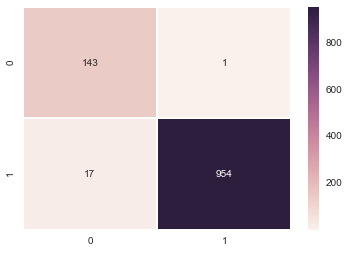

In [33]:
sns.heatmap(metrics.confusion_matrix(best_pipe.predict(X_test), y_test), annot=True,  fmt='');

In [34]:
print(metrics.classification_report(best_pipe.predict(X_test), y_test))

             precision    recall  f1-score   support

          0       0.89      0.99      0.94       144
          1       1.00      0.98      0.99       971

avg / total       0.99      0.98      0.98      1115



This is a small improvement for humanity and also for us sadly :(. But we could do better with a different classifier, with more parameters,
and even using grid search instead of randomized! There are paramters that wait for us to optimize!